In [500]:
# !pip install pmdarima
# !pip install chart_studio
import numpy as np
import pandas as pd
import operator
import matplotlib.pyplot as plt
import matplotlib as matplot
import seaborn as sns
import datetime
import pickle
from functools import reduce
from math import sqrt
from chart_studio.plotly import plot_mpl
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, max_error
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, LassoCV, ElasticNetCV, \
    RidgeCV, SGDRegressor, PassiveAggressiveRegressor

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# 1. Data Load and Exploratory Analysis

In [2]:
weekly_df = pd.read_pickle("./Data/agg_weekly_data.pkl")
daily_df = pd.read_pickle("./Data/agg_daily_data.pkl")

weekly_df.head()

,google_Self Driving Cars,google_Artificial Intelligence,google_IOT,google_Big Data,reddit_ai_compound,reddit_ai_neg,reddit_ai_neu,reddit_ai_pos,reddit_ai_count,reddit_ai_unique_authors,...,reddit_car_count,reddit_car_unique_authors,reddit_car_posts_per_author,reddit_iot_compound,reddit_iot_neg,reddit_iot_neu,reddit_iot_pos,reddit_iot_count,reddit_iot_unique_authors,reddit_iot_posts_per_author
2018-07-01,2.0,43.0,83.0,57.0,0.407604,0.010837,0.789388,0.199816,2.0,40.000000,...,1.0,28.000000,1.0,0.247625,0.055750,0.849875,0.094375,0.0,6.000000,11.0
2018-07-08,3.0,46.0,88.0,57.0,0.334494,0.031728,0.747607,0.220588,34.0,63.571429,...,21.0,41.000000,7.0,0.051780,0.055085,0.858881,0.086053,7.0,16.000000,0.0
2018-07-15,2.0,47.0,88.0,62.0,0.336037,0.030136,0.746171,0.223694,38.0,73.857143,...,25.0,54.142857,2.0,0.050286,0.060603,0.848389,0.090996,10.0,19.714286,10.0
2018-07-22,3.0,47.0,90.0,60.0,0.311115,0.033535,0.746237,0.220219,37.0,68.142857,...,27.0,48.857143,15.0,0.024231,0.055517,0.884480,0.060003,9.0,18.714286,7.0
2018-07-29,3.0,48.0,93.0,59.0,0.334759,0.028571,0.749804,0.221626,31.0,60.857143,...,29.0,58.571429,6.0,0.027215,0.029443,0.920855,0.049682,11.0,17.000000,23.0


In [3]:
daily_df.head()

,google_Self Driving Cars,google_Artificial Intelligence,google_IOT,google_Big Data,reddit_ai_compound,reddit_ai_neg,reddit_ai_neu,reddit_ai_pos,reddit_ai_count,reddit_ai_unique_authors,...,reddit_car_count,reddit_car_unique_authors,reddit_car_posts_per_author,reddit_iot_compound,reddit_iot_neg,reddit_iot_neu,reddit_iot_pos,reddit_iot_count,reddit_iot_unique_authors,reddit_iot_posts_per_author
2018-09-01,2.0,32.0,46.0,32.0,0.392174,0.022913,0.739652,0.237435,5.0,14,...,1.0,5,3.0,-0.109950,0.036833,0.963167,0.000000,1.0,5,3.0
2018-09-02,3.0,34.0,47.0,39.0,0.392014,0.007714,0.724857,0.267429,1.0,7,...,9.0,30,6.0,-0.070582,0.092545,0.831909,0.075545,2.0,10,2.0
2018-09-03,2.0,41.0,76.0,52.0,0.285135,0.033459,0.762018,0.204523,25.0,89,...,11.0,38,5.0,0.194154,0.008769,0.874231,0.117077,3.0,13,0.0
2018-09-04,2.0,48.0,88.0,60.0,0.378629,0.032289,0.724963,0.242770,31.0,111,...,23.0,68,8.0,-0.004127,0.070455,0.876318,0.053227,5.0,15,8.0
2018-09-05,3.0,48.0,89.0,61.0,0.399452,0.024226,0.748197,0.227587,48.0,142,...,24.0,78,5.0,0.149352,0.062778,0.836481,0.100741,6.0,17,10.0


In [197]:
result = seasonal_decompose(weekly_df, model='multiplicative')
fig = result.plot()
plot_mpl(fig)

ValueError: Multiplicative seasonality is not appropriate for zero and negative values

# 2. Data Prep

# 3. Modeling

## 3.1 ARIMA Model


### Helper Functions

In [310]:
# Accuracy metrics
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def forecast_accuracy(forecast, actual):
    mape = mean_absolute_percentage_error(actual, forecast)  # MAPE
    mae = mean_absolute_error(actual, forecast)  # MAE
    mse = mean_squared_error(actual, forecast)  # MSE
    rmse = sqrt(mse)  # RMSE
    r2 = r2_score(actual, forecast)  # r2
    max_errs = max_error(actual, forecast)  # max_errs
    return({'mape': mape, 'mae': mae, 'mse': mse,
            'rmse': rmse, 'r2': r2, 'max_errs': max_errs})


def run_ARIMA(df, train_start, train_stop, test_start, cv=5, verbose=False,
              temporal_intervals='weekly'):

    train = df.loc[train_start:train_stop]
    test = df.loc[test_start:]
    forecast_horizon = (df.index[len(df.index)-1] - test_start).days

    if temporal_intervals == 'weekly':
        forecast_horizon = round(forecast_horizon / 7) + 1

    stepwise_model = auto_arima(train,
                                start_p=1,
                                start_q=1,
                                start_P=0,
                                error_action='ignore',
                                suppress_warnings=True)

    stepwise_model.fit(train)
    forecast = stepwise_model.predict(n_periods=forecast_horizon)
    forecast = pd.DataFrame(forecast, index=test.index, columns=['Prediction'])

    metrics = forecast_accuracy(forecast, test)
    [print("{}: {}".format(score, metrics[score])) for score in metrics]

    if verbose:
        # plot the predictions for validation set
        plt.plot(train, label='Train')
        plt.plot(test, label='Valid')
        plt.plot(forecast, label='Prediction')
        plt.show()
    return(stepwise_model, metrics, forecast)

### 3.1.1 Target Only

In [311]:
# Modeling variables to set
train_start = pd.to_datetime('2018-07-01')
train_stop = pd.to_datetime('2018-10-07')
test_start = train_stop + datetime.timedelta(days=7)

exog_filter = ['count', 'unique_authors', 'per_author', 'google']

### 3.1.2 Exogenous Variables

In [510]:
exog_list = [col for feature in exog_filter for col in weekly_df.columns
             if feature in col]

exog_models = {}
results = {}
forecast_df = pd.DataFrame()
for var in exog_list:
    model_name = '%s_ARIMA_model_%s' % (var, test_start)
    try:
        print("Attempting to load %s from Models folder" % model_name)
        loaded_model = pickle.load(open('./Models/%s.sav' % model_name, 'rb'))
        results = pickle.load(open('./Models/arima_results_%s.txt' % test_start, 'rb'))
        forecast_df = pd.read_pickle("./Data/forecast_%s.pkl" % test_start)

    except FileNotFoundError:
        print("Load failed, retraining model")
        loaded_model, score, forecast = run_ARIMA(weekly_df.loc[:, var],
                                                  train_start,
                                                  train_stop,
                                                  test_start)

        pickle.dump(loaded_model, open('./Models/%s.sav' % model_name, 'wb'))
        results[model_name] = score

        temp = pd.DataFrame(forecast)
        temp.columns = [var+"_prediction_"]
        forecast_df = pd.concat([forecast_df, pd.DataFrame(forecast)], axis=1)

    exog_models[model_name] = (loaded_model, results[model_name])

pickle.dump(results, open('./Models/arima_results_%s.txt' % test_start, 'wb'))
forecast_df.to_pickle("./Data/forecast_%s.pkl" % test_start)

Attempting to load reddit_ai_count_ARIMA_model_2018-10-14 00:00:00 from Models folder
Attempting to load reddit_bdata_count_ARIMA_model_2018-10-14 00:00:00 from Models folder
Attempting to load reddit_car_count_ARIMA_model_2018-10-14 00:00:00 from Models folder
Attempting to load reddit_iot_count_ARIMA_model_2018-10-14 00:00:00 from Models folder
Attempting to load reddit_ai_unique_authors_ARIMA_model_2018-10-14 00:00:00 from Models folder
Attempting to load reddit_bdata_unique_authors_ARIMA_model_2018-10-14 00:00:00 from Models folder
Attempting to load reddit_car_unique_authors_ARIMA_model_2018-10-14 00:00:00 from Models folder
Attempting to load reddit_iot_unique_authors_ARIMA_model_2018-10-14 00:00:00 from Models folder
Attempting to load reddit_ai_posts_per_author_ARIMA_model_2018-10-14 00:00:00 from Models folder
Attempting to load reddit_bdata_posts_per_author_ARIMA_model_2018-10-14 00:00:00 from Models folder
Attempting to load reddit_car_posts_per_author_ARIMA_model_2018-10-14

In [314]:
forecast_df.head()

,reddit_ai_count_prediction_,reddit_bdata_count_prediction_,reddit_car_count_prediction_,reddit_iot_count_prediction_,reddit_ai_unique_authors_prediction_,reddit_bdata_unique_authors_prediction_,reddit_car_unique_authors_prediction_,reddit_iot_unique_authors_prediction_,reddit_ai_posts_per_author_prediction_,reddit_bdata_posts_per_author_prediction_,reddit_car_posts_per_author_prediction_,reddit_iot_posts_per_author_prediction_,google_Self Driving Cars_prediction_,google_Artificial Intelligence_prediction_,google_IOT_prediction_,google_Big Data_prediction_
2018-10-14,40.571429,50.533333,21.250178,9.333333,92.565568,99.657143,48.952381,18.171429,12.2,14.133333,8.933333,5.700074,4.648152,55.857143,96.711654,72.0
2018-10-21,43.142857,50.533333,23.000470,9.333333,104.273493,99.657143,48.952381,18.171429,12.2,14.133333,8.933333,10.052950,4.818004,56.714286,97.461911,73.0
2018-10-28,45.714286,50.533333,23.000470,9.333333,98.293287,99.657143,48.952381,18.171429,12.2,14.133333,8.933333,10.052950,4.987857,57.571429,98.218592,74.0


### 3.1.3 SARIMA Summaries

reddit_ai_count_ARIMA_model_2018-10-14 00:00:00                            Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                   15
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 -52.554
Date:                Fri, 01 Nov 2019   AIC                            109.107
Time:                        14:20:15   BIC                            110.385
Sample:                             0   HQIC                           108.989
                                 - 15                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.5714      4.016      0.640      0.522      -5.300      10.442
sigma2       106.6735     41.072      2.597      0.009      26.175     187.172
Ljun

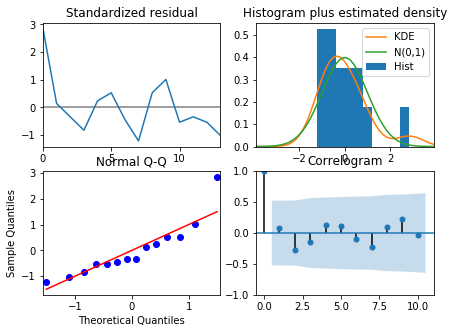

reddit_bdata_count_ARIMA_model_2018-10-14 00:00:00                            Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                   15
Model:                        SARIMAX   Log Likelihood                 -62.594
Date:                Fri, 01 Nov 2019   AIC                            129.188
Time:                        14:20:16   BIC                            130.604
Sample:                             0   HQIC                           129.173
                                 - 15                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     50.5333      4.335     11.658      0.000      42.038      59.029
sigma2       246.6489     66.844      3.690      0.000     115.636     377.661
L

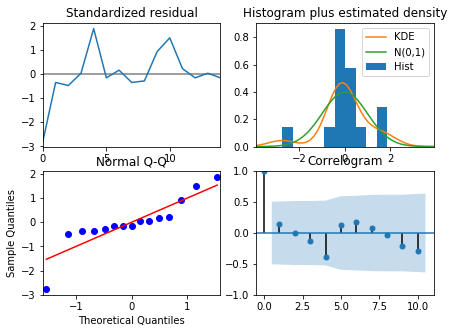

reddit_car_count_ARIMA_model_2018-10-14 00:00:00                            Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                   15
Model:               SARIMAX(0, 0, 1)   Log Likelihood                 -48.196
Date:                Fri, 01 Nov 2019   AIC                            102.392
Time:                        14:20:16   BIC                            104.516
Sample:                             0   HQIC                           102.369
                                 - 15                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     23.0005      3.801      6.051      0.000      15.551      30.450
ma.L1          0.9985     41.812      0.024      0.981     -80.952      82.949
sig

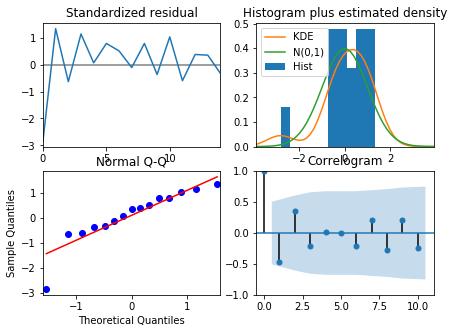

reddit_iot_count_ARIMA_model_2018-10-14 00:00:00                            Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                   15
Model:                        SARIMAX   Log Likelihood                 -40.686
Date:                Fri, 01 Nov 2019   AIC                             85.372
Time:                        14:20:17   BIC                             86.788
Sample:                             0   HQIC                            85.357
                                 - 15                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      9.3333      0.991      9.422      0.000       7.392      11.275
sigma2        13.2889      4.229      3.143      0.002       5.001      21.577
Lju

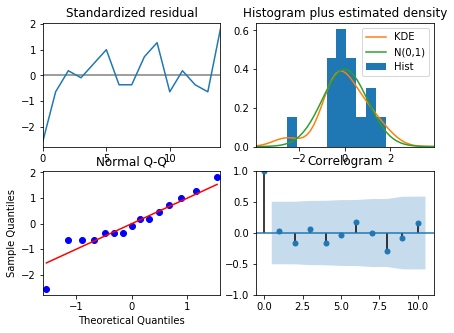

reddit_ai_unique_authors_ARIMA_model_2018-10-14 00:00:00                            Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                   15
Model:               SARIMAX(0, 1, 3)   Log Likelihood                 -48.626
Date:                Fri, 01 Nov 2019   AIC                            107.252
Time:                        14:20:17   BIC                            110.447
Sample:                             0   HQIC                           106.956
                                 - 15                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.3611      0.724      3.261      0.001       0.942       3.780
ma.L1         -0.9488   2007.026     -0.000      1.000   -3934.647    3932

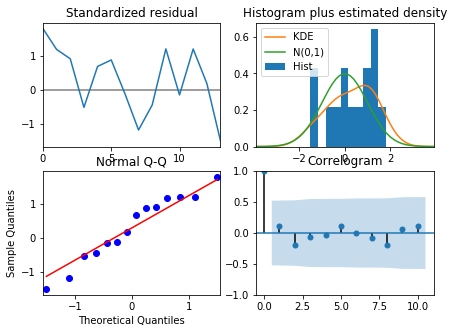

reddit_bdata_unique_authors_ARIMA_model_2018-10-14 00:00:00                            Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                   15
Model:                        SARIMAX   Log Likelihood                 -57.548
Date:                Fri, 01 Nov 2019   AIC                            119.096
Time:                        14:20:18   BIC                            120.512
Sample:                             0   HQIC                           119.081
                                 - 15                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     99.6571      3.548     28.087      0.000      92.703     106.611
sigma2       125.8634     43.673      2.882      0.004      40.266     

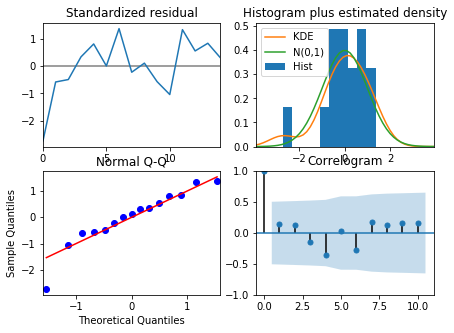

reddit_car_unique_authors_ARIMA_model_2018-10-14 00:00:00                            Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                   15
Model:                        SARIMAX   Log Likelihood                 -50.711
Date:                Fri, 01 Nov 2019   AIC                            105.422
Time:                        14:20:18   BIC                            106.838
Sample:                             0   HQIC                           105.407
                                 - 15                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     48.9524      2.637     18.562      0.000      43.784      54.121
sigma2        50.5814     17.774      2.846      0.004      15.745      8

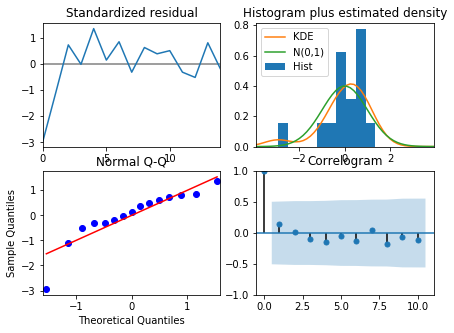

reddit_iot_unique_authors_ARIMA_model_2018-10-14 00:00:00                            Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                   15
Model:                        SARIMAX   Log Likelihood                 -44.237
Date:                Fri, 01 Nov 2019   AIC                             92.475
Time:                        14:20:18   BIC                             93.891
Sample:                             0   HQIC                            92.459
                                 - 15                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     18.1714      1.296     14.018      0.000      15.631      20.712
sigma2        21.3366      6.831      3.123      0.002       7.947      3

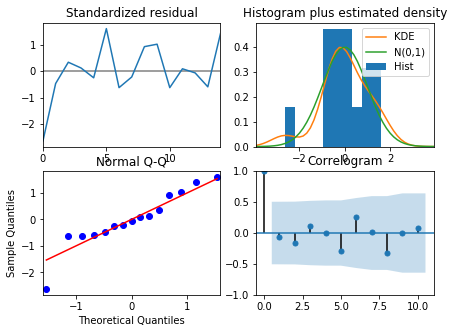

reddit_ai_posts_per_author_ARIMA_model_2018-10-14 00:00:00                            Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                   15
Model:                        SARIMAX   Log Likelihood                 -48.779
Date:                Fri, 01 Nov 2019   AIC                            101.557
Time:                        14:20:19   BIC                            102.974
Sample:                             0   HQIC                           101.542
                                 - 15                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     12.2000      2.509      4.862      0.000       7.282      17.118
sigma2        39.0933     18.607      2.101      0.036       2.625      

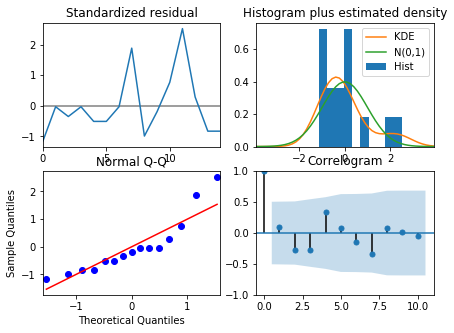

reddit_bdata_posts_per_author_ARIMA_model_2018-10-14 00:00:00                            Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                   15
Model:                        SARIMAX   Log Likelihood                 -64.701
Date:                Fri, 01 Nov 2019   AIC                            133.401
Time:                        14:20:19   BIC                            134.818
Sample:                             0   HQIC                           133.386
                                 - 15                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     14.1333     16.074      0.879      0.379     -17.371      45.637
sigma2       326.6489    550.935      0.593      0.553    -753.163   

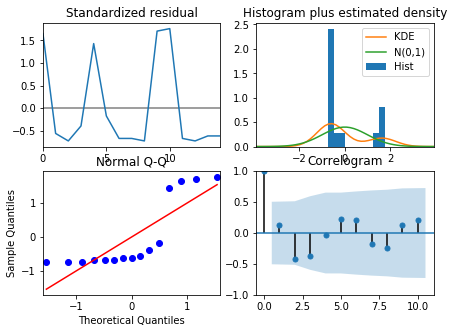

reddit_car_posts_per_author_ARIMA_model_2018-10-14 00:00:00                            Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                   15
Model:                        SARIMAX   Log Likelihood                 -44.928
Date:                Fri, 01 Nov 2019   AIC                             93.856
Time:                        14:20:20   BIC                             95.272
Sample:                             0   HQIC                            93.841
                                 - 15                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      8.9333      1.295      6.899      0.000       6.395      11.471
sigma2        23.3956     10.344      2.262      0.024       3.121     

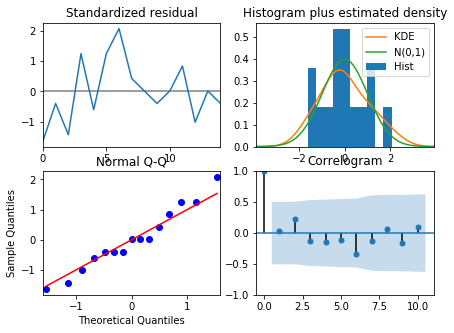

reddit_iot_posts_per_author_ARIMA_model_2018-10-14 00:00:00                            Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                   15
Model:               SARIMAX(0, 0, 1)   Log Likelihood                 -48.788
Date:                Fri, 01 Nov 2019   AIC                            103.576
Time:                        14:20:20   BIC                            105.700
Sample:                             0   HQIC                           103.554
                                 - 15                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     10.0529      0.344     29.211      0.000       9.378      10.727
ma.L1         -0.9995     93.501     -0.011      0.991    -184.259     

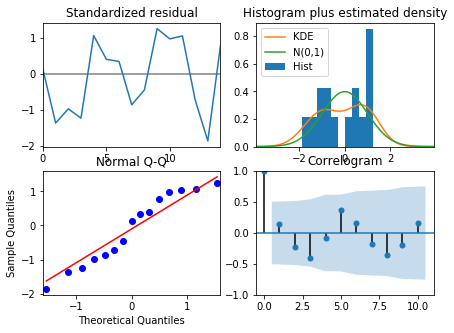

google_Self Driving Cars_ARIMA_model_2018-10-14 00:00:00                            Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                   15
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 -12.179
Date:                Fri, 01 Nov 2019   AIC                             30.359
Time:                        14:20:21   BIC                             32.276
Sample:                             0   HQIC                            30.181
                                 - 15                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1699      0.073      2.332      0.020       0.027       0.313
ma.L1         -0.7090      0.344     -2.063      0.039      -1.383      -0

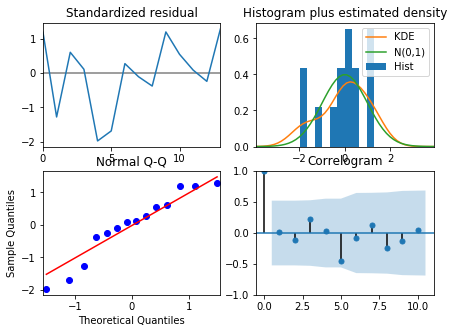

google_Artificial Intelligence_ARIMA_model_2018-10-14 00:00:00                            Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                   15
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 -31.103
Date:                Fri, 01 Nov 2019   AIC                             66.205
Time:                        14:20:21   BIC                             67.483
Sample:                             0   HQIC                            66.087
                                 - 15                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.8571      0.635      1.349      0.177      -0.388       2.103
sigma2         4.9796      1.901      2.619      0.009       1.254  

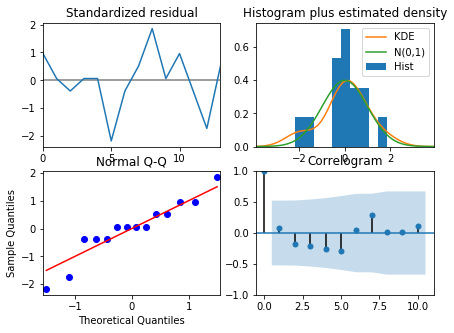

google_IOT_ARIMA_model_2018-10-14 00:00:00                            Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                   15
Model:               SARIMAX(0, 1, 2)   Log Likelihood                 -32.429
Date:                Fri, 01 Nov 2019   AIC                             72.858
Time:                        14:20:21   BIC                             75.414
Sample:                             0   HQIC                            72.621
                                 - 15                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.7567      0.355      2.131      0.033       0.061       1.453
ma.L1         -0.3515    346.238     -0.001      0.999    -678.966     678.263
ma.L2    

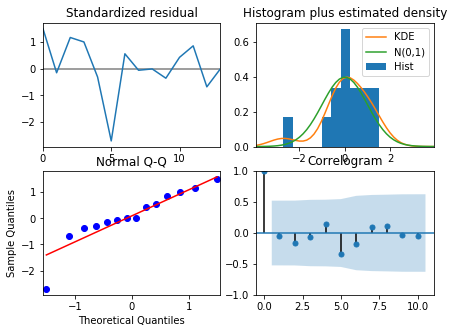

google_Big Data_ARIMA_model_2018-10-14 00:00:00                            Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                   15
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 -32.066
Date:                Fri, 01 Nov 2019   AIC                             68.132
Time:                        14:20:22   BIC                             69.410
Sample:                             0   HQIC                            68.014
                                 - 15                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.0000      0.794      1.260      0.208      -0.556       2.556
sigma2         5.7143      3.590      1.592      0.111      -1.323      12.751
Ljun

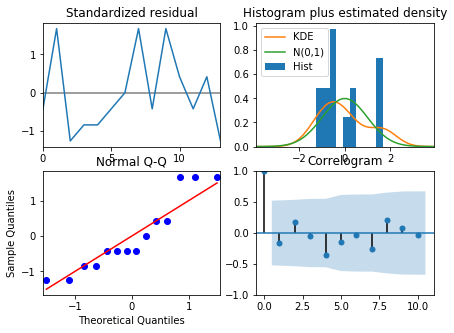

In [315]:
for x in exog_models:
    print(x, exog_models[x][0].summary())
    exog_models[x][0].plot_diagnostics(figsize=(7,5))
    plt.show()

In [563]:
for x in exog_models:
    exog_models[x][0].plot_predict(dynamic=False)
    plt.show()

AttributeError: 'ARIMA' object has no attribute 'plot_predict'

## 3.2 Regression Model

### Data Preparation Helper Functions

In [331]:
def drop_columns(df, columns_to_drop):
    new_df = df.copy()
    return new_df.drop(columns_to_drop, axis=1)


def standardize_data(df, st_cols):
    std_scale = MinMaxScaler().fit(df[st_cols])
    df[st_cols] = std_scale.transform(df[st_cols])
    return df


def prep_data(df, st_cols, target, columns_to_drop=[]):
    new_df = df.copy()
    return standardize_data(drop_columns(new_df, columns_to_drop), st_cols)

### Modeling Helper Functions

In [558]:
def get_best_model(results_list, best_cross_val=False):
    """ 
        Given a dictionary of model results, returns the model with the best MAE
        score either for the validation set or Cross-Validation.

    """
    values = list(results_list.values())
    keys = list(results_list.keys())
    
    if best_cross_val:
        best_index = [x for x, y in enumerate(values) 
                      if y[1] == min(values, key=operator.itemgetter(1))[1]]
    else:
        best_index = [x for x, y in enumerate(values) 
                      if y[0] == min(values)[0]]
    return (keys[best_index[0]], results_list[keys[best_index[0]]])


def score_model(df, target, train_start, train_stop, test_start, model, cv=5,
                metric='neg_median_absolute_error'):
    """
        Splits inputed dataframe into a train/test splits based on user specifications. 
        These splits will be used to fit a pipeline based on the entered algorithm
        and validated against a hold out as well as through time series 
        cross-validation. Returns the best estimator and cv scores.
    """

    test = df.loc[test_start:]
    train = df.loc[train_start:train_stop]
    X_train = train.loc[:, (train.columns != target) & (train.columns != target)]
    y_train = train.loc[:, target]

    X_test = test.loc[:, (test.columns != target) & (test.columns != target)]
    y_test = pd.Series(test.loc[:, target], index=X_test.index.values)

    pipeline = Pipeline([(model[0], model[1])])
    
    # Obtain scores and estimators from different splits and use the best one.
    time_series_cv = TimeSeriesSplit(n_splits=cv)
    scores = cross_validate(pipeline,
                            X_train,
                            y_train,
                            scoring=metric,
                            cv=time_series_cv,
                            return_estimator=True)

    # Make predictions on holdout using each fold's model, to find best MAE
    split_scores = [mean_absolute_error(y_test,
                                        pd.Series(scores['estimator'][i].predict(X_test),
                                                  index=y_test.index.values))
                    for i in range(len(scores))]
    index_best = split_scores.index(min(split_scores))
    print('Best estimator MAE score: {:.3f}'.format(split_scores[index_best]))
    return(scores['estimator'][index_best], split_scores[index_best], np.array(split_scores))


def tune_model(df, target, train_start, train_stop, test_start, model, param, seed=12345,
               cv=5, n_jobs=-1, gridSearch=False, verbose=True,
               metric='neg_median_absolute_error'):
    """
        Splits inputed dataframe into a train/test splits based on user specifications. 
        These splits will be used to fit a pipeline based on the entered algorithm. 
        Returns an optimally tuned pipeline based on inputed parameters.

        NOTE: Randomized Search can be implemented to reduce computation time.
        --------
    """
    test = df.loc[test_start:]
    train = df.loc[train_start:train_stop]
    X_train = train.loc[:, (train.columns != target) & (train.columns != target)]
    y_train = train.loc[:, target]

    X_test = test.loc[:, (test.columns != target) & (test.columns != target)]
    y_test = pd.Series(test.loc[:, target], index=X_test.index.values)

    pipeline = Pipeline([(model[0], model[1])])
    time_series_cv = TimeSeriesSplit(n_splits=cv)

    # Toggle to run Grid Search or Randomized Search (to save on computation time)
    if(gridSearch):
        gsearch = GridSearchCV(estimator=pipeline,
                               param_grid=param,
                               scoring=metric,
                               n_jobs=n_jobs,
                               cv=time_series_cv,
                               verbose=verbose)
    else:
        gsearch = RandomizedSearchCV(estimator=pipeline,
                                     param_distributions=param,
                                     scoring=metric,
                                     n_jobs=n_jobs,
                                     cv=time_series_cv,
                                     random_state=seed,
                                     verbose=verbose)

    gsearch.fit(X_train, y_train)
    tuned_model = gsearch.best_estimator_

    if(verbose):
        print('='*20)
        print("best params: " + str(gsearch.best_estimator_))
        print("best params: " + str(gsearch.best_params_))
        print('best score:', gsearch.best_score_)
        print('='*20)

    # Make predictions on holdout using each fold's model, to find best MAE
    holdout_score = mean_absolute_error(y_test,
                                       pd.Series(tuned_model.predict(X_test),
                                                 index=y_test.index.values))
    return(tuned_model, holdout_score)

### 3.2.1 Basline Model 

In [562]:
target = 'google_Self Driving Cars'
seed = 12345
models = []

# Neural Nets
models.append(('NN', MLPRegressor()))

# Generalized Linear Models
models.append(('LR', LinearRegression()))
models.append(('Lasso', LassoCV()))
models.append(('Ridge', RidgeCV()))
models.append(('Elastic_Net', ElasticNetCV()))
models.append(('SGD', SGDRegressor()))
models.append(('PAR', PassiveAggressiveRegressor()))

# Nearest Neighbors
models.append(('KNN', KNeighborsRegressor()))

# Decision Trees
models.append(('DTR', DecisionTreeRegressor()))
models.append(('ETR', ExtraTreeRegressor()))

# Ensembles
models.append(('RFR', KNeighborsRegressor()))
models.append(('GB', GradientBoostingRegressor()))

# Run preparation pipeline
prepared_df = prep_data(weekly_df,
                        weekly_df.loc[:, weekly_df.columns != target].columns,
                        target)

# evaluate each model in turn
regression_models = {}
results = {}
for name, model in models:
    model_name = '%s_baseline_model' % (name)
    try:
        print("Attempting to load %s from Models folder" % model_name)
        loaded_model = pickle.load(open('./Models/%s.sav' % model_name, 'rb'))
        results = pickle.load(open('./Models/regression_results.txt', 'rb'))

    except FileNotFoundError:
        print("Load failed, retraining model")
        loaded_model, validation_score, cv_results = score_model(prepared_df,
                                                                 target,
                                                                 train_start,
                                                                 train_stop,
                                                                 test_start,
                                                                 (name, model))
        pickle.dump(loaded_model, open('./Models/%s.sav' % model_name, 'wb'))
        results[model_name] = (validation_score, cv_results.mean(), cv_results.std())

    regression_models[model_name] = loaded_model
    print("%s MAE: Validation: %f, CV %f +/- %f" % (model_name,
                                                    results[model_name][0],
                                                    results[model_name][1],
                                                    results[model_name][2]))

pickle.dump(results, open('./Models/regression_results.txt', 'wb'))

Attempting to load NN_baseline_model from Models folder
NN_baseline_model MAE: Validation: 1.282452, CV 1.626478 +/- 0.227689
Attempting to load LR_baseline_model from Models folder
LR_baseline_model MAE: Validation: 1.862415, CV 2.594600 +/- 0.432675
Attempting to load Lasso_baseline_model from Models folder
Lasso_baseline_model MAE: Validation: 2.312742, CV 2.462033 +/- 0.100414
Attempting to load Ridge_baseline_model from Models folder
Ridge_baseline_model MAE: Validation: 2.145243, CV 2.371886 +/- 0.150039
Attempting to load Elastic_Net_baseline_model from Models folder
Elastic_Net_baseline_model MAE: Validation: 2.283764, CV 2.449934 +/- 0.105972
Attempting to load SGD_baseline_model from Models folder
SGD_baseline_model MAE: Validation: 1.776906, CV 2.109834 +/- 0.215227
Attempting to load PAR_baseline_model from Models folder
PAR_baseline_model MAE: Validation: 1.339861, CV 2.309180 +/- 0.561173
Attempting to load KNN_baseline_model from Models folder
KNN_baseline_model MAE: Val

In [560]:
get_best_model(results)

('ETR_baseline_model', (1.0, 2.0833333333333335, 0.7216878364870322))

In [559]:
get_best_model(results, best_cross_val=True)

('NN_baseline_model',
 (1.2824523811843853, 1.626478118067665, 0.22768904411870902))

#### 3.2.2 Feature Engineering

#### 3.2.3 Feature Elimination

#### 3.2.4 Hyperparameter Tuning

In [561]:
model_name = 'Tuned_NN'

try:
    print("Attempting to load tuned model")
    tuned_model = pickle.load(open('./Models/%s.sav' % model_name, 'rb'))

except FileNotFoundError:
    print("Load failed, retraining model")
    param = {
        '{}__C'.format(model_name): [0.5, 1, 2]
    }

    model_object = (model_name, regression_models[get_best_model(results)[0]])
    tuned_model, validation_score = tune_model(prepared_df,
                                               target,
                                               train_start,
                                               train_stop,
                                               test_start,
                                               model_object,
                                               param,
                                               target,
                                               gridSearch=True)

regression_models[model_name] = tuned_model
results[model_name] = (cv_results.mean(), cv_results.std())

Attempting to load tuned model
Load failed, retraining model
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


ValueError: Invalid parameter C for estimator Pipeline(memory=None,
         steps=[('ETR',
                 ExtraTreeRegressor(criterion='mse', max_depth=None,
                                    max_features='auto', max_leaf_nodes=None,
                                    min_impurity_decrease=0.0,
                                    min_impurity_split=None, min_samples_leaf=1,
                                    min_samples_split=2,
                                    min_weight_fraction_leaf=0.0,
                                    random_state=None, splitter='random'))],
         verbose=False). Check the list of available parameters with `estimator.get_params().keys()`.

## 3.3 Combined Models